In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from PIL import Image
from tqdm import tqdm
from scipy.signal import correlate2d
import cv2
from scipy import ndimage, datasets
import time
from scipy.interpolate import griddata

np.set_printoptions(precision=2)

In [20]:
PATCH_SIZE = 5
HALF_SIZE = PATCH_SIZE // 2

PATCH_REGION = lambda i, j : (slice(i - HALF_SIZE, i + HALF_SIZE + 1), \
                              slice(j - HALF_SIZE, j + HALF_SIZE + 1))

# SAFE_PATCH_REGION = lambda i, j, h, w : (slice(max(0, i - HALF_SIZE), min(h, i + HALF_SIZE + 1)), \
#                                          slice(max(0, j - HALF_SIZE), min(w, j + HALF_SIZE + 1)))

def SAFE_PATCH_REGION(i, j, h, w, halflen=HALF_SIZE, cutoff_edges=False):
    minval = HALF_SIZE if cutoff_edges else 0

    return slice(max(minval, i - halflen), min(h - minval, i + halflen + 1)), \
           slice(max(minval, j - halflen), min(w - minval, j + halflen + 1))


def REGION_INTERSECT(ij1, r1, ij2, r2):
    # For region 1
    i1, j1 = ij1
    i2, j2 = ij2

    r1_y0, r1_x0, r1_y1, r1_x1 = r1[0].start, r1[1].start, r1[0].stop, r1[1].stop
    r2_y0, r2_x0, r2_y1, r2_x1 = r2[0].start, r2[1].start, r2[0].stop, r2[1].stop

    top = min(i1 - r1_y0, i2 - r2_y0)
    bottom = min(r1_y1 - i1, r2_y1 - i2)
    right = min(r1_x1 - j1, r2_x1 - j2)
    left = min(j1 - r1_x0, j2 - r2_x0)

    region1 = (slice(i1 - top, i1 + bottom), slice(j1 - left, j1 + right))
    region2 = (slice(i2 - top, i2 + bottom), slice(j2 - left, j2 + right))

    return region1, region2
    

MASK_COLOR = [0, 255, 0]

N_PATCH_MATCH_ITERS = 20

In [21]:
# image = np.ones((512, 512, 3), dtype=np.int64) * 200
# mask = np.zeros((512, 512), dtype=bool)

# for r in range(image.shape[0]):
#     for c in range(image.shape[1]):
#         if 512-30 <= (r + c) <= 512+30:
#             image[r, c] = 0

#         if (r - 256) ** 2 + (c - 256) ** 2 <= 64 ** 2:
#             mask[r, c] = 1

In [22]:
def in_bounds(r, c, h, w, dilated=False):
    starter = HALF_SIZE if dilated else 0
    return (r >= starter and r < h - starter) and (c >= starter and c < w - starter)
    
def masked_image(img, mask):
    return ~mask[:, :, np.newaxis] * img + (mask[:, :, np.newaxis]) * MASK_COLOR

image = Image.open('menmax.jpg')
image = np.array(image)

mask = Image.open('menmax-mask.jpg')
mask = np.mean(np.array(mask), axis=-1)
mask = mask < 128

height, width, channels = image.shape

"""count_erosions_mask = mask.copy()
N_o = 0

while count_erosions_mask.any():
    erosion = ndimage.binary_erosion(count_erosions_mask, structure=np.ones((3, 3)))
    boundary = count_erosions_mask ^ erosion

    N_o += 1

    count_erosions_mask = erosion

n_pyramid_levels = np.ceil( np.log2(2 * N_o / (PATCH_SIZE * PATCH_SIZE)) ).astype(int)"""

n_pyramid_levels = 4
print(f"{n_pyramid_levels} Pyramid Levels")

# Create greyscale image from RGB image for calculating image gradients
grey_image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
gradient_y, gradient_x = np.abs(np.gradient(grey_image.astype(float)))
gradient = np.stack([gradient_x, gradient_y], axis=-1)

# Calculate the finest level texture map from absolute values of image gradients
texture = np.empty(shape=(height, width, 2))

for i in range(height):
    for j in range(width):
        sidelen = 1 + 2 ** (n_pyramid_levels - 1)
        texture_region = SAFE_PATCH_REGION(i, j, height, width, halflen=sidelen//2)
        
        cardinality = sidelen * sidelen

        texture[i, j, 0] = 1/cardinality * np.sum(gradient[texture_region][..., 0])
        texture[i, j, 1] = 1/cardinality * np.sum(gradient[texture_region][..., 1])


fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(masked_image(image, mask))
axs[0].axis('off')

axs[1].imshow(texture[...,0])
axs[1].axis('off')

axs[2].imshow(texture[...,1])
axs[2].axis('off')

plt.tight_layout()
plt.show()

4 Pyramid Levels


KeyboardInterrupt: 

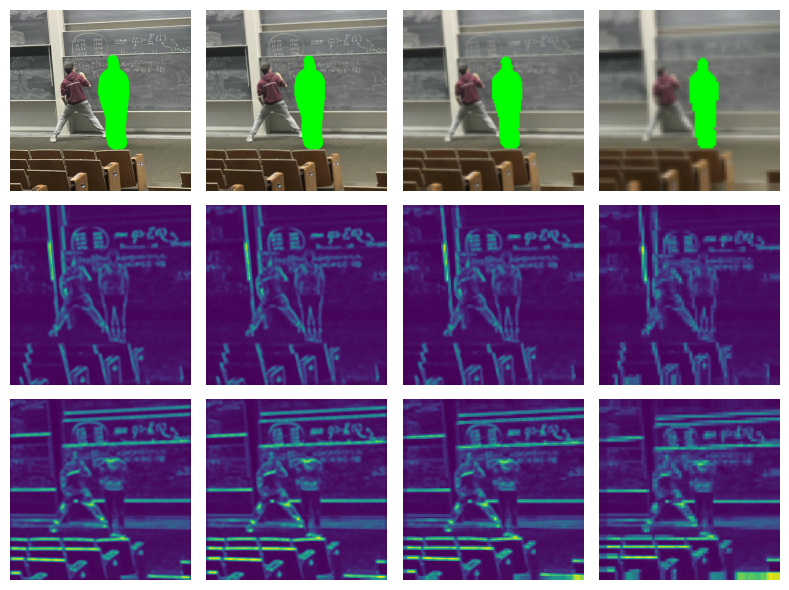

In [ ]:
# Create the pyramids for image, texture, and mask; downsample by factor of 2 at each level
    # TODO: this may only work well for image sizes which are powers of 2 (?)
    # IMPORTANT: the texture pyramid at level l + 1 is not created from level l, but rather by taking farther and farther
    # pixels from the level 0 texture map (prevents dissapearing textures)

image_pyramid = [image.copy()]
texture_pyramid = [texture.copy()]
mask_pyramid = [mask.copy()]

for i in range(1, n_pyramid_levels):
    # Apply Gaussian 3x3 kernel and downsample image
    next_level_image = ndimage.gaussian_filter(image_pyramid[-1], sigma=(1, 1, 0))[::2, ::2]
    image_pyramid.append(next_level_image)

    # Downsample texture map
    multiplier = 2 ** i
    next_level_texture = texture_pyramid[0][::multiplier, ::multiplier]
    texture_pyramid.append(next_level_texture)

    # Downsample the mask using (2x2) max pooling OR take every other pixel
    # TODO: figure out which method is best
    
    # next_level_mask = ndimage.maximum_filter(mask_pyramid[-1], size=(2, 2))[::2, ::2]
    next_level_mask = mask_pyramid[-1][::2, ::2]
    mask_pyramid.append(next_level_mask)

padding_width = [(HALF_SIZE, HALF_SIZE), (HALF_SIZE, HALF_SIZE), (0, 0)]

# To prevent out of bounds errors, pad the image/texture/map at all levels with half the patch size
# around the borders
for i in range(0, n_pyramid_levels):
    image_pyramid[i] = np.pad(image_pyramid[i], pad_width=padding_width, mode='edge')
    texture_pyramid[i] = np.pad(texture_pyramid[i], pad_width=padding_width, mode='edge')
    mask_pyramid[i] = np.pad(mask_pyramid[i], pad_width=padding_width[:-1], mode='constant', constant_values=0)

fig, axs = plt.subplots(3, len(image_pyramid), figsize=(8, 6))
for i, (img, msk, txtr) in enumerate(zip(image_pyramid, mask_pyramid, texture_pyramid)):
    axs[0, i].imshow(masked_image(img, msk))
    axs[0, i].axis('off')

    axs[1, i].imshow(txtr[..., 0])
    axs[1, i].axis('off')

    axs[2, i].imshow(txtr[..., 1])
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()


In [70]:
rho = 0.5
lam = 50
    
def partial_dist(image, texture, mask, patch_center_A, patch_center_B):
    """Calculates the distance between two patches in an image and texture. This function is only to be used
    during initialization where, when we compare a patch which has some of it masked, we do not include
    masked values of the image in the comparison calculations

    Args:
        image (ndarray): The original image as a 3D numpy array (H x W x 3).
        texture (ndarray): The texture as a 3D numpy array (H x W x 2).
        mask (ndarray): The mask as a 2D numpy array (H x W).
        patch_center_A (tuple): The row and column coordinates of the center of patch A.
        patch_center_B (tuple): The row and column coordinates of the center of patch B.

    Returns:
        float: The distance between the two patches.
    """
    image_h, image_w, _ = image.shape

    i_A, j_A = patch_center_A
    i_B, j_B = patch_center_B

    region_A = PATCH_REGION(i_A, j_A)
    region_B = PATCH_REGION(i_B, j_B)

    region_A_mask = mask[region_A][:, :, np.newaxis]

    region_A_image = image[region_A]
    region_A_texture = texture[region_A]

    region_B_image = image[region_B]
    region_B_texture = texture[region_B]

    partial_patch_area = np.sum((~region_A_mask).astype(int))

    masked_region_A_image = region_A_image * ~region_A_mask
    masked_region_A_texture = region_A_texture * ~region_A_mask

    masked_region_B_image = region_B_image * ~region_A_mask
    masked_region_B_texture = region_B_texture * ~region_A_mask
    
    ssd_image = np.sum(np.square(masked_region_A_image - masked_region_B_image))
    ssd_texture = np.sum(np.square(masked_region_A_texture - masked_region_B_texture))

    return 1/partial_patch_area * (ssd_image + lam * ssd_texture)

def dist(image, texture, mask, patch_center_A, patch_center_B):
    """Calculates the distance between two patches in an image and texture.

    Args:
        image (ndarray): The original image as a 3D numpy array (H x W x 3).
        texture (ndarray): The texture as a 3D numpy array (H x W x 2).
        mask (ndarray): The mask as a 2D numpy array (H x W).
        patch_center_A (tuple): The row and column coordinates of the center of patch A.
        patch_center_B (tuple): The row and column coordinates of the center of patch B.

    Returns:
        float: The distance between the two patches.
    """
    image_h, image_w, _ = image.shape

    i_A, j_A = patch_center_A
    i_B, j_B = patch_center_B

    region_A = PATCH_REGION(i_A, j_A)
    region_B = PATCH_REGION(i_B, j_B)

    region_A_image = image[region_A]
    region_A_texture = texture[region_A]

    region_B_image = image[region_B]
    region_B_texture = texture[region_B]

    patch_area = PATCH_SIZE * PATCH_SIZE
    
    try:
        ssd_image = np.sum(np.square(region_A_image - region_B_image))
        ssd_texture = np.sum(np.square(region_A_texture - region_B_texture))
    except:
        print(region_A.start, region_A.stop)
        print(region_B.start, region_B.stop)

    return 1/patch_area * (ssd_image + lam * ssd_texture)

def ann(image, texture, mask, shift_map, init=False, boundary_mask=None, shrinking_mask=None):
    """Performs the Approximate Nearest Neighbor (ANN) search on the given image and texture.
    This uses the PatchMatch algorithm for progatation, random search steps

    Args:
        image (ndarray): The original image as a 3D numpy array (H x W x 3).
        texture (ndarray): The texture as a 3D numpy array (H x W x 2).
        mask (ndarray): The mask as a 2D numpy array (H x W).
        shift_map (ndarray): The shift map as a 3D numpy array (H x W x 2).
        init (bool, optional): If True, perform onion-peel initialization of the image hole.
        boundary_mask (ndarray, optional): The boundary mask as a 2D numpy array (H x W). Defaults to None.
        shrinking_mask (ndarray, optional): The shrinking mask as a 2D numpy array (H x W). Defaults to None.

    Returns:
        ndarray: The distance map where distance_map[r, c] contains the patch distance between the patch at (r, c)
        and its approximate nearest neighbor
    """
    dist_fn = dist if not init else partial_dist

    image_h, image_w, image_c = image.shape
    max_dimension = max(image_h, image_w)

    structure_element = np.ones((PATCH_SIZE, PATCH_SIZE))

    dilated_mask = ndimage.binary_dilation(mask, structure=structure_element)

    filled_rows, filled_cols = np.where(dilated_mask == 1)
    min_row, max_row = np.min(filled_rows), np.max(filled_rows)
    min_col, max_col = np.min(filled_cols), np.max(filled_cols)

    mask_width, mask_height = max_col - min_col, max_row - min_row
    jump_flood_max = max(mask_width, mask_height)

    jump_flood_radii = [max_dimension]
    while jump_flood_radii[-1] > 1:
        jump_flood_radii.append(jump_flood_radii[-1] // 2)
    
    jump_flood_radii += [2, 1]

    offsets = {
        0: [np.array([0, 0], dtype=int), np.array([-1, 0], dtype=int), np.array([0, -1], dtype=int)],
        1: [np.array([0, 0], dtype=int), np.array([1, 0], dtype=int), np.array([0, 1], dtype=int)]
    }

    image_indices = {
        0: ([HALF_SIZE, image_h - HALF_SIZE, 1], [HALF_SIZE, image_w - HALF_SIZE, 1]),
        1: ([image_h - HALF_SIZE - 1, HALF_SIZE - 1, -1], [image_w - HALF_SIZE - 1, HALF_SIZE - 1, -1]),
    }

    distance_map = np.zeros(shape=(image_h, image_w))
    
    for _ in range(10):
        for i in range(len(jump_flood_radii)):
            radius = jump_flood_radii[i]

            shift_map_copy = shift_map.copy()

            for r in range(HALF_SIZE, image_h - HALF_SIZE, 1):
                for c in range(HALF_SIZE, image_w - HALF_SIZE, 1):
                    if init and not boundary_mask[r, c]: continue
                    elif not init and not dilated_mask[r, c]: continue

                    curr_coord = np.array([ r, c ])
                    min_shift, min_dist = shift_map[r, c], dist_fn(image, texture, shrinking_mask, curr_coord, curr_coord + shift_map[r, c])

                    radii_offsets = [-radius, 0, radius]

                    for dr in radii_offsets:
                        for dc in radii_offsets:
                            partner_r, partner_c = r + dr, c + dc
                            if not in_bounds(partner_r, partner_c, image_h, image_w, dilated=True): continue

                            candidate_r, candidate_c = curr_coord + shift_map[partner_r, partner_c]
                            if not in_bounds(candidate_r, candidate_c, image_h, image_w, dilated=True): continue

                            candidate_distance = dist_fn(image, texture, shrinking_mask, curr_coord, (candidate_r, candidate_c))

                            if not dilated_mask[candidate_r, candidate_c] and candidate_distance < min_dist:
                                min_dist = candidate_distance
                                min_shift = shift_map[partner_r, partner_c]

                    shift_map_copy[r, c] = min_shift
                    distance_map[r, c] = min_dist

                    alpha = 1.0
                    original_shift = shift_map_copy[r, c]

                    while alpha * max_dimension >= 1:
                        rand_uniform = np.random.uniform(-1, 1, 2)

                        offset = np.floor(max_dimension * alpha * rand_uniform).astype(np.int64)
                        q_i, q_j = curr_coord + original_shift + offset

                        if in_bounds(q_i, q_j, image_h, image_w, dilated=True) and not dilated_mask[q_i, q_j]:
                            q_distance = dist_fn(image, texture, shrinking_mask, curr_coord, (q_i, q_j))

                            if q_distance < distance_map[r, c]:
                                shift_map_copy[r, c] = original_shift + offset
                                distance_map[r, c] = q_distance
                    
                        alpha *= rho
        
            shift_map = shift_map_copy


    # # ANN Search
    # for k in range(10):
    #     r_range, c_range = image_indices[k%2]
    #     coord_ox = offsets[k%2]

    #     for r in range(*r_range):
    #         for c in range(*c_range):
    #             if init and not boundary_mask[r, c]: continue
    #             elif not init and not dilated_mask[r, c]: continue

    #             # Propagation stage
    #             curr_coord = np.array([r, c])

    #             min_shift, min_dist = shift_map[r, c], dist_fn(image, texture, shrinking_mask, curr_coord, curr_coord + shift_map[r, c])
                
    #             for (shift_i, shift_j) in coord_ox:
    #                 correspondant_i, correspondant_j = r + shift_i, c + shift_j
                    
    #                 if not in_bounds(correspondant_i, correspondant_j, image_h, image_w, dilated=True): 
    #                     continue
                    
    #                 # candidate_shift_i, candidate_shift_j = shift_map[correspondant_i, correspondant_j]
    #                 candidate_i, candidate_j = curr_coord + shift_map[correspondant_i, correspondant_j]

    #                 if not in_bounds(candidate_i, candidate_j, image_h, image_w, dilated=True): 
    #                     continue

    #                 candidate_distance = dist_fn(image, texture, shrinking_mask, curr_coord, (candidate_i, candidate_j))

    #                 if not dilated_mask[candidate_i, candidate_j] and candidate_distance < min_dist:
    #                     # print(f"Accepting neighbor value for {r,c} from {correspondant_i, correspondant_j}")
    #                     min_dist = candidate_distance
    #                     min_shift = shift_map[correspondant_i, correspondant_j]

    #             shift_map[r, c] = min_shift
    #             distance_map[r, c] = min_dist

                
    #             # Random search stage
    #             # cov_mat = (max_dimension / 3) ** 2 * np.eye(2)
    #             # NN = int(np.log2(max_dimension))
    #             # for _ in range(NN):
    #             #     candidate_i, candidate_j = r, c

    #             #     while not in_bounds(candidate_i, candidate_j, image_h, image_w, dilated=True) or dilated_mask[candidate_i, candidate_j]:
    #             #         candidate_i, candidate_j = np.random.multivariate_normal(mean=[r, c], cov=cov_mat).astype(np.int64)

    #             #     candidate_dist = dist_fn(image, texture, shrinking_mask, curr_coord, (candidate_i, candidate_j))
    #             #     if candidate_distance < distance_map[r, c]:
    #             #         shift_map[r, c] = [candidate_i - r, candidate_j - c]
    #             #         distance_map[r, c] = candidate_dist

    #             alpha = 1.0
    #             original_shift = shift_map[r, c]

    #             while alpha * max_dimension >= 1:
    #                 rand_uniform = np.random.uniform(-1, 1, 2)

    #                 offset = np.floor(max_dimension * alpha * rand_uniform).astype(np.int64)
    #                 q_i, q_j = curr_coord + original_shift + offset

    #                 if in_bounds(q_i, q_j, image_h, image_w, dilated=True) and not dilated_mask[q_i, q_j]:
    #                     q_distance = dist_fn(image, texture, shrinking_mask, curr_coord, (q_i, q_j))

    #                     if q_distance < distance_map[r, c]:
    #                         shift_map[r, c] = original_shift + offset
    #                         distance_map[r, c] = q_distance

    #                     # q_shift = shift_map[q_i, q_j]
    #                     # candidate_coord = curr_coord + q_shift

    #                     # if in_bounds(*candidate_coord, image_h, image_w, dilated=True):
    #                     #     q_distance = dist_fn(image, texture, shrinking_mask, curr_coord, candidate_coord)

    #                     #     if not dilated_mask[candidate_coord[0], candidate_coord[1]] and q_distance < distance_map[r, c]:
    #                     #         shift_map[r, c] = q_shift
    #                     #         distance_map[r, c] = q_distance
                
    #                 alpha *= rho

    return distance_map, shift_map

def reconstruction(image, texture, mask, shift_map, distance_map, init=False, boundary_mask=None, shrinking_mask=None):
    """
    This function reconstructs the image and texture based on the given shift map and distance map. 
    It uses a neighborhood-based approach to calculate the weighted sum of image and texture pixels.

    Args:
        image (ndarray): The original image as a 3D numpy array (H x W x 3).
        texture (ndarray): The texture as a 3D numpy array (H x W x 2).
        mask (ndarray): The mask as a 2D numpy array (H x W).
        shift_map (np.array): The ANN field as a 3D numpy array (H x W x 2).
        distance_map (np.array): The distance map as a 2D numpy array (H x W).
        init (bool, optional): If True, perform reconstruction only on boundary_mask pixels.
        boundary_mask (np.array, optional): If init, the pixels on the current onion-peel boundary. Defaults to None.
        shrinking_mask (np.array, optional): If init, the shrinking hole mask. Defaults to None.
    """
    if init: assert boundary_mask is not None

    image_h, image_w, image_c = image.shape

    for r in range(HALF_SIZE, image_h - HALF_SIZE, 1):
        for c in range(HALF_SIZE, image_w - HALF_SIZE, 1):
            if init and not boundary_mask[r, c]: continue
            elif not init and not mask[r, c]: continue

            neighborhood = SAFE_PATCH_REGION(r, c, image_h, image_w, cutoff_edges=True)
            neighborhood_distances = distance_map[neighborhood]
            neighborhood_shifts = shift_map[neighborhood]

            region_area = neighborhood_distances.shape[0] * neighborhood_distances.shape[1]

            q = 75
            if init:
                n_masked = np.sum(shrinking_mask[neighborhood])
                neighborhood_distances *= ~shrinking_mask[neighborhood]
                q = 100.0 * (n_masked + 0.75 * (region_area - n_masked)) / region_area

            sigma_p = max(1e-6, np.percentile(neighborhood_distances, q=q))
            
            scores = np.exp(-neighborhood_distances / (2 * sigma_p ** 2))
            if init:
                scores *= ~shrinking_mask[neighborhood]

            total_scores = np.sum(scores)

            pixels_with_shifts = np.array([r, c])[np.newaxis, np.newaxis, :] + neighborhood_shifts
            
            weighted_image_pixels = scores[:, :, np.newaxis] * image[pixels_with_shifts[..., 0], pixels_with_shifts[..., 1]]
            weighted_texture_pixels = scores[:, :, np.newaxis] * texture[pixels_with_shifts[..., 0], pixels_with_shifts[..., 1]]

            image_pixel = np.sum(weighted_image_pixels, axis=(0, 1)) / total_scores
            texture_pixel = np.sum(weighted_texture_pixels, axis=(0, 1)) / total_scores

            image[r, c] = image_pixel
            texture[r, c] = texture_pixel

def upsample_shift_map(shift_map):
    """
    Upsamples the shift map by doubling its size and adjusting the shifts accordingly.

    Args:
        shift_map (np.array): The ANN field as a 3D numpy array (H x W x 2).

    Returns:
        np.array: The upsampled ANN field as a 3D numpy array (2H x 2W x 2).
    """
    image_h, image_w, _ = shift_map.shape
    new_image_h, new_image_w = 2 * (image_h - 2 * HALF_SIZE) + 2 * HALF_SIZE, 2 * (image_w - 2 * HALF_SIZE) + 2 * HALF_SIZE

    upsampled_shift_map = np.empty(shape=(new_image_h, new_image_w, 2), dtype=np.int64)

    for r in range(HALF_SIZE, new_image_h - HALF_SIZE, 1):
        for c in range(HALF_SIZE, new_image_w - HALF_SIZE, 1):
            translated_r, translated_c = r - HALF_SIZE, c - HALF_SIZE
            downsampled_r, downsampled_c = translated_r // 2 + HALF_SIZE, translated_c // 2 + HALF_SIZE

            upsampled_shift_map[r, c] = 2 * shift_map[downsampled_r, downsampled_c]
    
    return upsampled_shift_map

def upsample_distance_map(upsampled_image, upsampled_texture, upsampled_mask, upsampled_shift_map):
    """
    Upsamples the distance map by calculating the distance between the upsampled image and texture, 
    taking into account the upsampled mask and shift map.

    Args:
        upsampled_image (np.array): The upsampled image as a 3D numpy array (H x W x 3).
        upsampled_texture (np.array): The upsampled texture as a 3D numpy array (H x W x 3).
        upsampled_mask (np.array): The upsampled mask as a 2D numpy array (H x W).
        upsampled_shift_map (np.array): The upsampled ANN field as a 3D numpy array (H x W x 2).

    Returns:
        np.array: The upsampled distance map as a 2D numpy array (H x W).
    """
    image_h, image_w, _ = upsampled_shift_map.shape
    upsampled_distance_map = np.zeros(shape=(image_h, image_w))

    for r in range(HALF_SIZE, image_h - HALF_SIZE, 1):
        for c in range(HALF_SIZE, image_w - HALF_SIZE, 1):
            curr_coord = np.array([r, c])
            upsampled_shift = upsampled_shift_map[r, c]

            upsampled_distance_map[r, c] = dist(upsampled_image, upsampled_texture, upsampled_mask,
                                                curr_coord, curr_coord + upsampled_shift)
    
    return upsampled_distance_map

def final_image_reconstruction(image, mask, shift_map, distance_map):
    """
    Reconstructs the final image using the given image, mask, shift map, and distance map.
    This function is different from reconstruction() since it does not score-weight pixels in a 
    neighborhood to fill in a given pixel. It instead takes the best pixel in the neighborhood and uses that
    pixel's ANN

    Args:
        image (np.array): The original image as a 3D numpy array (H x W x 3).
        mask (np.array): The mask as a 2D numpy array (H x W), indicating the regions to be reconstructed.
        shift_map (np.array): The ANN field as a 3D numpy array (H x W x 2), indicating the shifts for each pixel.
        distance_map (np.array): The distance map as a 2D numpy array (H x W).
    """
    image_h, image_w, _ = image.shape

    for r in range(HALF_SIZE, image_h - HALF_SIZE, 1):
        for c in range(HALF_SIZE, image_w - HALF_SIZE, 1):
            if not mask[r, c]: continue

            min_distance = distance_map[r, c]
            min_coord = (r, c)

            for rr in range(max(HALF_SIZE, r - HALF_SIZE), min(image_h - HALF_SIZE, r + HALF_SIZE)):
                for cc in range(max(HALF_SIZE, c - HALF_SIZE), min(image_w - HALF_SIZE, c + HALF_SIZE)):
                    if distance_map[rr, cc] < min_distance:
                        min_distance = distance_map[rr, cc]
                        min_coord = (rr, cc)
            
            correspondant_shift = shift_map[min_coord[0], min_coord[1]]
            image[r, c] = image[r + correspondant_shift[0], c + correspondant_shift[1]]


def outline_patch(image, point1, point2, patch_size, mask=None):
    image_copy = image.copy()

    if mask is not None:
        image_copy[mask] = [0, 0, 0]

    image_copy[point1[0], point1[1]] = [255, 0, 0]
    image_copy[point2[0], point2[1]] = [0, 0, 255]
    
    fig = plt.figure(figsize=(4, 5))
    gs = fig.add_gridspec(3,2)

    ax1 = fig.add_subplot(gs[0:2, :]); ax1.axis('off')
    ax2 = fig.add_subplot(gs[2, 0]); ax2.axis('off')
    ax3 = fig.add_subplot(gs[2, 1]); ax3.axis('off')

    ax1.imshow(image_copy)
    ax2.imshow(image[PATCH_REGION(*point1)])
    ax3.imshow(image[PATCH_REGION(*point2)])

    plt.tight_layout()
    plt.show()

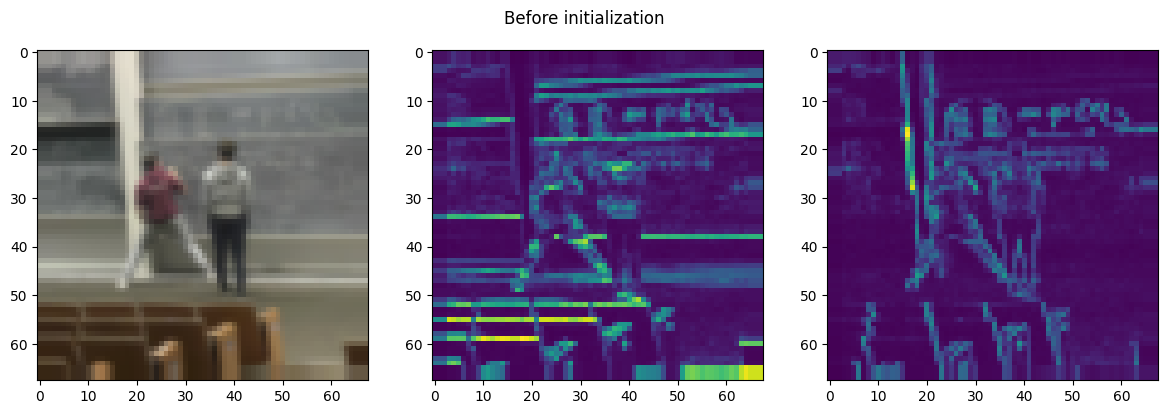

Shrinking inward...
Shrinking inward...
Shrinking inward...
Shrinking inward...
Shrinking inward...
Shrinking inward...
Shrinking inward...
Shrinking inward...


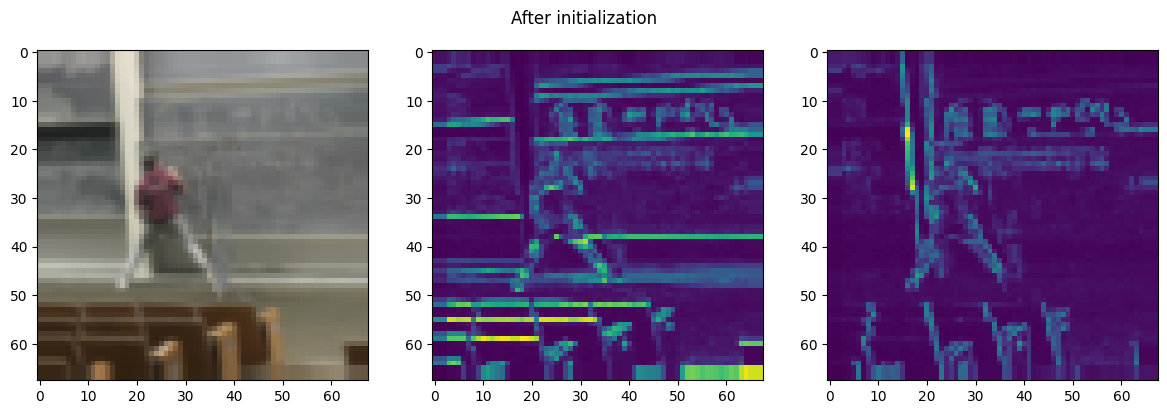

In [71]:
# Inpainting initialization with onion peel
structure_element = np.ones((PATCH_SIZE, PATCH_SIZE))
cross = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])

coarse_mask = mask_pyramid[-1].copy()
dilated_coarse_mask = ndimage.binary_dilation(coarse_mask, structure=structure_element)
eroded_mask = ndimage.binary_erosion(dilated_coarse_mask, structure=cross)
boundary_mask = dilated_coarse_mask ^ eroded_mask

coarse_texture = texture_pyramid[-1].copy()
coarse_image = image_pyramid[-1].copy()

level_height, level_width, _ = coarse_image.shape

shift_map = np.zeros(shape=(level_height, level_width, 2), dtype=np.int64) # Initialize shift map

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Before initialization")
ax[0].imshow(coarse_image)
ax[1].imshow(coarse_texture[...,1])
ax[2].imshow(coarse_texture[...,0])

plt.tight_layout()
plt.show()

# Initialize values of shift map by setting unoccluded neighborhoods to 0, and for any pixel in an occluded neighborhood,
# initialize its starting shift to be random in the image in an unoccluded neighborhood
for r in range(HALF_SIZE, level_height - HALF_SIZE):
    for c in range(HALF_SIZE, level_width - HALF_SIZE):
        random_i, random_j = r, c

        while dilated_coarse_mask[random_i, random_j]:
            random_i, random_j = np.random.randint(HALF_SIZE, level_height - HALF_SIZE), np.random.randint(HALF_SIZE, level_width - HALF_SIZE)
        
        shift_i, shift_j = random_i - r, random_j - c
        shift_map[r, c] = [shift_i, shift_j]

# Onion peel initialization of image and texture at coarsest level
shrinking_mask = dilated_coarse_mask.copy()
lvl = 0

while shrinking_mask.any():
    print("Shrinking inward...")
    eroded_mask = ndimage.binary_erosion(shrinking_mask, structure=cross)
    boundary_mask = shrinking_mask ^ eroded_mask
    # plt.imshow(boundary_mask); plt.show()
    # print(boundary_mask[53, 40])

    distance_map, shift_map = ann(coarse_image, coarse_texture, coarse_mask,
        shift_map=shift_map,
        init=True,
        boundary_mask=boundary_mask,
        shrinking_mask=shrinking_mask)

    if lvl >= HALF_SIZE:    
        reconstruction(coarse_image, coarse_texture, coarse_mask,
                    shift_map=shift_map,
                    distance_map=distance_map,
                    init=True,
                    boundary_mask=boundary_mask,
                    shrinking_mask=shrinking_mask)
    
    shrinking_mask = eroded_mask
    lvl += 1

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("After initialization")
ax[0].imshow(coarse_image)
ax[1].imshow(coarse_texture[...,1])
ax[2].imshow(coarse_texture[...,0])

plt.tight_layout()
plt.show()

Beginning level 3.................
   Level = 3, k = 1, e = 142.27060
   Level = 3, k = 2, e = 1.56950
   Level = 3, k = 3, e = 0.63100
   Level = 3, k = 4, e = 0.00123


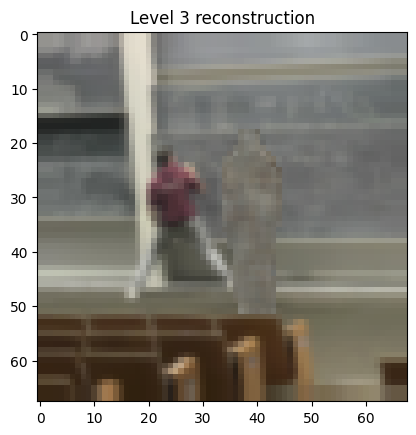

Beginning level 2.................
   Level = 2, k = 1, e = 2.40960
   Level = 2, k = 2, e = 0.56215


AttributeError: 'tuple' object has no attribute 'start'

In [ ]:
# The main inpainting algorithm

curr_image = coarse_image
curr_texture = coarse_texture
curr_mask = coarse_mask
curr_shift_map = shift_map

# Work backwards from coarsest to finest pyramid level
for l in range(n_pyramid_levels-1, -1, -1):
    print(f"Beginning level {l}.................")
    k = 0
    e = 1

    while e > 0.15 and k < 10:        
        v = curr_image.copy()
        distance_map = ann(curr_image, curr_texture, curr_mask,
                           shift_map=shift_map)
        reconstruction(curr_image, curr_texture, curr_mask,
                       shift_map=shift_map,
                       distance_map=distance_map)

        curr_hole_size = np.sum(curr_mask)

        masked_previous_image = v * curr_mask[:, :, np.newaxis]
        masked_updated_image = curr_image * curr_mask[:, :, np.newaxis]

        e = 1/(3*curr_hole_size) * np.sum(np.abs(masked_updated_image - masked_previous_image))
        k += 1

        print(f"   Level = {l}, k = {k}, e = {e:.5f}")

    # If at the final level, don't upsample and instead reconstruct the final image
    if l == 0:
        plt.imshow(curr_image)
        plt.title(f"Final reconstruction")
        plt.show()
        
        final_image_reconstruction(curr_image, curr_mask,
                                   shift_map=shift_map,
                                   distance_map=distance_map)
    # Otherwise, upsample the image/texture/map/shift_map/distance_map to double the size
    else:
        plt.imshow(curr_image)
        plt.title(f"Level {l} reconstruction")
        plt.show()
        
        upsampled_image = image_pyramid[l - 1]
        upsampled_texture = texture_pyramid[l - 1]
        upsampled_mask = mask_pyramid[l - 1]

        upsampled_shift_map = upsample_shift_map(shift_map)
        upsampled_distance_map = upsample_distance_map(upsampled_image, upsampled_texture, upsampled_mask, upsampled_shift_map)

        reconstruction(upsampled_image, upsampled_texture, upsampled_mask,
                    shift_map=upsampled_shift_map,
                    distance_map=upsampled_distance_map)
        
        curr_image = upsampled_image
        curr_texture = upsampled_texture
        curr_mask = upsampled_mask
        shift_map = upsampled_shift_map


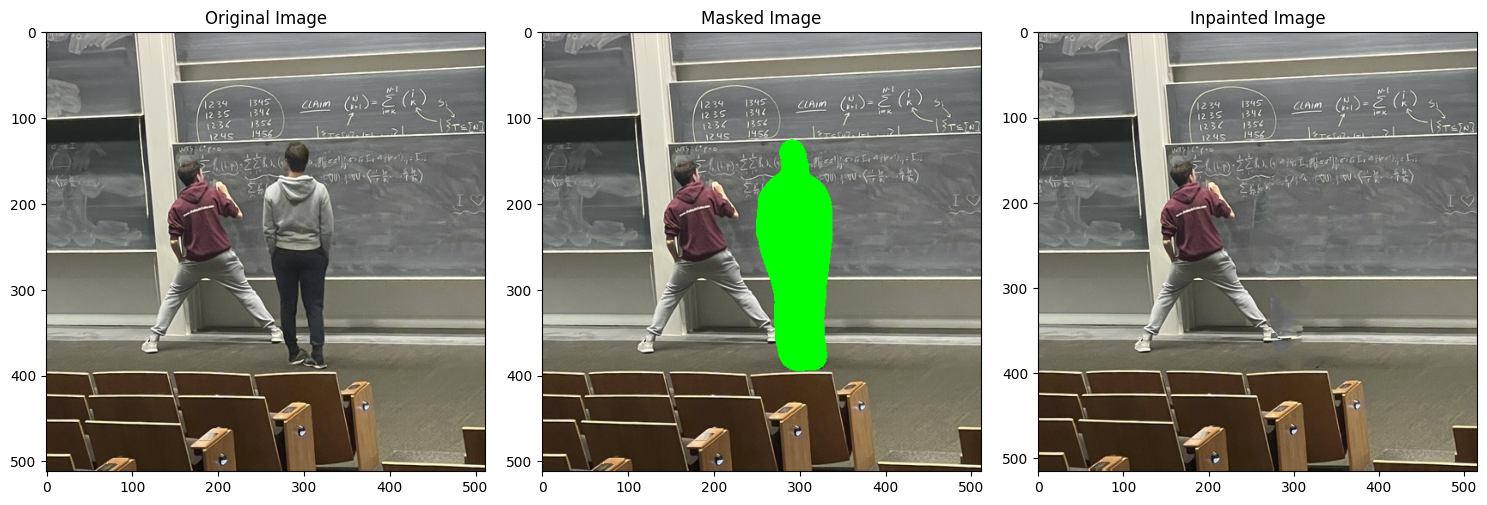

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(masked_image(image, mask))
ax[1].set_title("Masked Image")
ax[2].imshow(curr_image)
ax[2].set_title("Inpainted Image")

plt.tight_layout()
plt.savefig("menmax-done.png")
plt.show()
